Analysis of a Ctx network for figures 3 and 4.

In [1]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
import matplotlib
from low_rank_rnns import mante, ranktwo, clustering, helpers, mante_regressions, rankone
import seaborn as sns

In [2]:
helpers.setup_matplotlib()
col_ctx1 = '#840045'
col_ctx2 = '#ae8844'
col_sig1 = '#d3dd16' #'#faa72a'
col_sig2 = '#d3dd16'
col_sig3 = '#faa72a'
col_stim_period = 'silver'
col_response_period = 'sandybrown'
colors = ['seagreen', 'rebeccapurple']

In [3]:
def time_mapping(t):
    return t * mante.deltaT / 1000

In [4]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
mante.SCALE_CTX = .5
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_rank1_{hidden_size}.pt', map_location='cpu'))


In [5]:
loss_orig, acc_orig = mante.test_mante(net, x_val, y_val, mask_val)
print(loss_orig)
print(acc_orig)

0.01830800250172615
0.9950000047683716


In [6]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()
vecs = clustering.make_vecs(net)

# Positivity adjustments
n = -n
m = -m

In [7]:
n_pops = 2
vecs = clustering.make_vecs(net)
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020)

z = 1 - z   # inverting population labels for presentation purposes

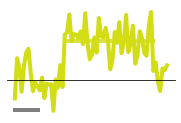

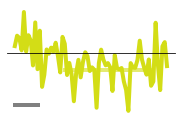

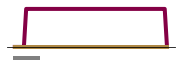

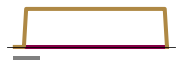

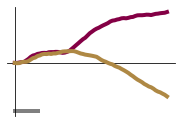

In [8]:
plt.rcParams['text.usetex'] = True

net.noise_std = noise_std
x = torch.zeros((2, mante.total_duration, 4))
x[:, :, :2] += mante.std_default * torch.randn((1, mante.total_duration, 2))
x[:, mante.stim_begin:mante.stim_end, 0] += 2 * mante.SCALE
x[:, mante.stim_begin:mante.stim_end, 1] -= 1 * mante.SCALE
x[0, mante.fixation_duration_discrete:mante.response_begin, 2] += mante.SCALE_CTX
x[1, mante.fixation_duration_discrete:mante.response_begin, 3] += mante.SCALE_CTX
outp1, trajectories = net.forward(x, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates = np.tanh(trajectories)
time = time_mapping(np.arange(x.shape[1]))

fig, ax = plt.subplots(figsize=(3, 2))
x = x.squeeze().numpy()
ax.plot(time, x[0, :, 0], lw=4, c=col_sig1)
ax.plot(time[mante.stim_begin:mante.stim_end], [2 * mante.SCALE] * (mante.stim_end - mante.stim_begin), alpha=.8, lw=4, c=col_sig1)
#ax.set_axis_off()
helpers.center_axes(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.plot([0, 0.2], [-.15, -.15], c='gray', lw=4)
# plt.savefig('figure_3/mante_input1.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time, x[0, :, 1], lw=4, c=col_sig2)
ax.plot(time[mante.stim_begin:mante.stim_end], [-1 * mante.SCALE] * (mante.stim_end - mante.stim_begin), alpha=.6, lw=4, c=col_sig2)
#ax.set_axis_off()
helpers.center_axes(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.plot([0, 0.2], [-.3, -.3], c='gray', lw=4)
# plt.savefig('figure_3/mante_input2.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 1))
ax.plot(time, x[0, :, 2], lw=4, c=col_ctx1)
ax.plot(time, x[1, :, 2], lw=4, c=col_ctx2)
#ax.set_axis_off()
helpers.center_axes(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.plot([0, 0.2], [-.15, -.15], c='gray', lw=4)
# plt.savefig('figure_3/mante_input3.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 1))
ax.plot(time, x[0, :, 3], lw=4, c=col_ctx1)
ax.plot(time, x[1, :, 3], lw=4, c=col_ctx2)
#ax.set_axis_off()
helpers.center_axes(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.plot([0, 0.2], [-.15, -.15], c='gray', lw=4)
# plt.savefig('figure_3/mante_input4.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 2))
outp1 = outp1.detach().squeeze().numpy()
ax.plot(time_mapping(np.arange(outp1.shape[1])), outp1[0], color=col_ctx1, zorder=30, lw=4)
ax.plot(time_mapping(np.arange(outp1.shape[1])), outp1[1], color=col_ctx2, zorder=30, lw=4)
# ax.set_axis_off()
helpers.center_axes(ax)
ax.plot([0, 0.2], [-1, -1], c='gray', lw=4)
# plt.savefig('figure_3/mante_output.pdf', bbox_inches='tight')

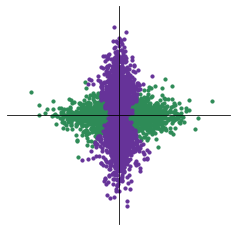

pop 0: slope=-0.48, intercept=-0.02
pop 1: slope=0.76, intercept=-0.05


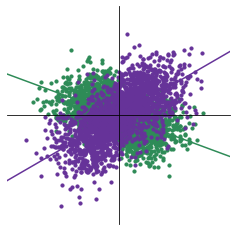

pop 0: slope=0.78, intercept=0.01
pop 1: slope=-0.47, intercept=0.04


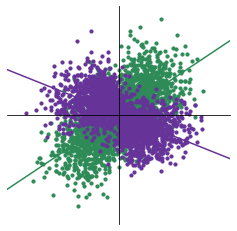

In [9]:

fig, ax = plt.subplots(figsize=(4, 4))
clustering.pop_scatter_linreg(wi_ctx1, wi_ctx2, z, 2, colors=colors, linreg=False, ax=ax)
# plt.savefig('figure_4/mante_scatter1.pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(4, 4))
clustering.pop_scatter_linreg(n, wi1, z, 2, colors=colors, ax=ax)
# plt.savefig('figure_4/mante_scatter2.pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(4, 4))
clustering.pop_scatter_linreg(n, wi2, z, 2, colors=colors, ax=ax)
# plt.savefig('figure_4/mante_scatter3.pdf', bbox_inches='tight')
plt.show()


In [10]:
x_train2, y_train2, mask_train2, x_val2, y_val2, mask_val2 = mante.generate_mante_data(1000)

In [11]:
# Resample a few networks
losses_normal = []
accs_normal = []

n_samples = 10
net2 = clustering.to_support_net(net, np.zeros(hidden_size))
for _ in range(n_samples):
    net2.resample_basis()
    loss, acc = mante.test_mante(net2, x_val2, y_val2, mask_val2)
    losses_normal.append(loss)
    accs_normal.append(acc)

losses2 = []
accs2 = []
net3 = clustering.to_support_net(net, z)
for _ in range(n_samples):
    net3.resample_basis()
    loss, acc = mante.test_mante(net3, x_val2, y_val2, mask_val2)
    losses2.append(loss)
    accs2.append(acc)


In [12]:
accs_normal

[0.7699999809265137,
 0.7149999737739563,
 0.7699999809265137,
 0.7200000286102295,
 0.699999988079071,
 0.7400000095367432,
 0.7149999737739563,
 0.7450000047683716,
 0.7699999809265137,
 0.7250000238418579]

In [13]:
accs2

[0.925000011920929,
 0.9599999785423279,
 0.949999988079071,
 0.9399999976158142,
 0.9399999976158142,
 0.9350000023841858,
 0.9850000143051147,
 0.9649999737739563,
 0.9399999976158142,
 0.9700000286102295]

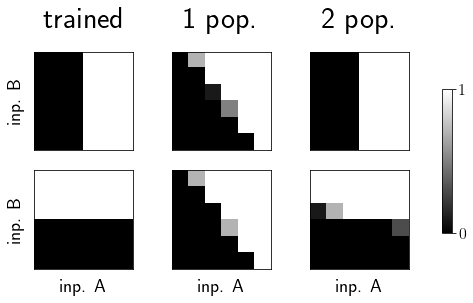

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(7, 4))
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 27

mante.psychometric_matrices(net, axes=[ax[0][0], ax[1][0]])
mante.psychometric_matrices(net2, axes=[ax[0][1], ax[1][1]])
mante.psychometric_matrices(net3, axes=[ax[0][2], ax[1][2]])

ax[0][0].set_title('trained')
ax[0][0].set_ylabel('inp. B')
ax[0][1].set_title('1 pop.')
ax[0][2].set_title('2 pop.')
ax[1][0].set_ylabel('inp. B')
for i in range(3):
    ax[1][i].set_xlabel('inp. A')
    
ax_cbar = fig.add_axes([.95, .25, .02, .5])
# ax_cbar.set_axis_off()
cbar = matplotlib.colorbar.ColorbarBase(ax=ax_cbar, cmap=matplotlib.cm.gray, boundaries=np.linspace(0, 1, 100))
cbar.set_ticks([0, 1])

fig.subplots_adjust(hspace=.2)

# ax[0][3].set_axis_off()
# ax[1][3].set_axis_off()
# ax[0][3].text(.4, .5, 'Ctx A', va='center', ha='center')
# ax[1][3].text(.4, .5, 'Ctx B', va='center', ha='center')

# plt.savefig('figure_3/mante_psycho.pdf', bbox_inches='tight')

<AxesSubplot:ylabel='accuracy'>

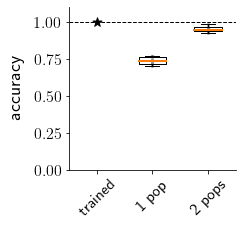

In [15]:
plt.rcParams['axes.labelsize'] = 19
helpers.boxplot_accuracies([acc_orig, accs_normal, accs2], labels=['trained', '1 pop', '2 pops'],
                          figsize=(3, 3))
# plt.savefig('figure_3/mante_resampling.pdf', bbox_inches='tight')

In [16]:
x1, _, _, _, _, _ = mante.generate_mante_data(1, coherences=[0.], std=0., context_spec=1)
outp, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes1 = helpers.phi_prime(trajectories[mante.stim_begin:mante.stim_end].mean(axis=0))
x2, _, _, _, _, _ = mante.generate_mante_data(1, coherences=[0.], std=0., context_spec=2)
outp, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes2 = helpers.phi_prime(trajectories[mante.stim_begin:mante.stim_end].mean(axis=0))

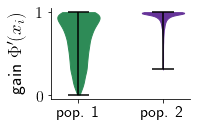

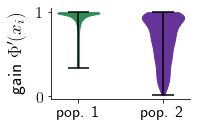

In [18]:
plt.rcParams['text.usetex'] = True
figsize = (2.5, 2.5 / 3 * 2)

fig, ax = plt.subplots(figsize=figsize)
pl = ax.violinplot([phi_primes1[z==i] for i in range(2)])
ax.set_yticks([0, 1])
ax.set_xticks([1, 2])
ax.set_xticklabels(['pop. 1', 'pop. 2'])
pl['bodies'][0].set_color(colors[0])
pl['bodies'][0].set_alpha(1)
pl['bodies'][1].set_color(colors[1])
pl['bodies'][1].set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('gain $\\Phi\'(x_i)$')
# plt.savefig('figure_4/mante_gain1.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=figsize)
pl = ax.violinplot([phi_primes2[z==i] for i in range(2)])
ax.set_yticks([0, 1])
ax.set_xticks([1, 2])
ax.set_xticklabels(['pop. 1', 'pop. 2'])
pl['bodies'][0].set_color(colors[0])
pl['bodies'][0].set_alpha(1)
pl['bodies'][1].set_color(colors[1])
pl['bodies'][1].set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('gain $\\Phi\'(x_i)$')
# plt.savefig('figure_4/mante_gain2.pdf', bbox_inches='tight')
plt.show()


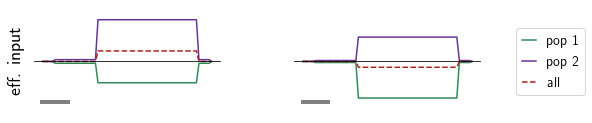

In [19]:
x = torch.zeros((2, mante.total_duration, 4))
x[:, :, :2] += mante.std_default * torch.zeros((1, mante.total_duration, 2))
x[:, mante.stim_begin:mante.stim_end, 0] += 2 * mante.SCALE
x[:, mante.stim_begin:mante.stim_end, 1] -= 1 * mante.SCALE
x[0, mante.fixation_duration_discrete:mante.response_begin, 2] += mante.SCALE_CTX
x[1, mante.fixation_duration_discrete:mante.response_begin, 3] += mante.SCALE_CTX
outp1, trajectories = net.forward(x, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()

inp_integration1 = np.tanh(np.outer(x[0, :, 0], wi1) + np.outer(x[0, :, 1], wi2) + np.outer(x[0, :, 2], wi_ctx1) + 
                         np.outer(x[0, :, 3], wi_ctx2))
inp1_pop1 = inp_integration1[:, z==0] @ n[z==0].reshape((-1, 1)) / np.sum(1-z)
inp1_pop2 = inp_integration1[:, z==1] @ n[z==1].reshape((-1, 1)) / np.sum(z)
inp1_global = inp_integration1 @ n.reshape((-1, 1)) / net.hidden_size
inp_integration2 = np.tanh(np.outer(x[1, :, 0], wi1) + np.outer(x[1, :, 1], wi2) + np.outer(x[1, :, 2], wi_ctx1) + 
                         np.outer(x[1, :, 3], wi_ctx2))
inp2_pop1 = inp_integration2[:, z==0] @ n[z==0].reshape((-1, 1)) / np.sum(1-z)
inp2_pop2 = inp_integration2[:, z==1] @ n[z==1].reshape((-1, 1)) / np.sum(z)
inp2_global = inp_integration2 @ n.reshape((-1, 1)) / net.hidden_size
time = time_mapping(np.arange(x.shape[1]))

fig, ax = plt.subplots(1, 2, figsize=(8, 2))
pl1, = ax[0].plot(time, inp1_pop1, c=colors[0])
pl2, = ax[0].plot(time, inp1_pop2, c=colors[1])
pl3, = ax[0].plot(time, inp1_global, ls='--', c='firebrick')
ax[0].spines['bottom'].set_position('zero')
ax[0].spines['left'].set_visible(False)
ax[0].set_xticks([])
ax[0].set(ylim=(-.4, .4), yticks=[], ylabel='eff. input')
ax[0].plot([0, 0.2], [-.3, -.3], c='gray', lw=4)

ax[1].plot(time, inp2_pop1, c=colors[0])
ax[1].plot(time, inp2_pop2, c=colors[1])
pl4, = ax[1].plot(time, inp2_global, ls='--', c='firebrick')
ax[1].set(ylim=(-.4, .4), yticks=[],  xticks=[])
ax[1].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_visible(False)
fig.subplots_adjust(wspace=.4)
fig.legend([pl1, pl2, pl3], ['pop 1', 'pop 2', 'all'], 
           bbox_to_anchor=(.95, .5), handlelength=1, loc='center left')
ax[1].plot([0, 0.2], [-.3, -.3], c='gray', lw=4)
# plt.savefig('figure_4/mante_kappainp.pdf', bbox_inches='tight')

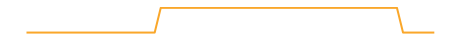

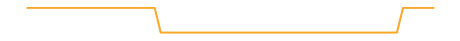

In [20]:
fig, ax = plt.subplots(figsize=(8, .5))
ax.plot(time, x[0, :, 0].numpy(), c=col_sig3, lw=2)
ax.set(xticks=[], yticks=[])
ax.set_axis_off()
# plt.savefig('figure_4/mante_miniinp1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, .5))
ax.plot(time, x[0, :, 1].numpy(), c=col_sig3, lw=2)
ax.set_axis_off()
# plt.savefig('figure_4/mante_miniinp2.pdf', bbox_inches='tight')
plt.show()

[[ True False False False False False False]
 [ True  True False False False False False]
 [ True  True  True False False False False]
 [ True  True  True  True False False False]
 [ True  True  True  True  True False False]
 [ True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True]]
[[ 0.00000000e+00 -4.37009732e-01  7.30132154e-02  2.70435664e-02
  -7.86585099e-01 -6.49844740e-01 -1.45051042e-01]
 [ 0.00000000e+00  0.00000000e+00 -7.71003287e-02  3.16390554e-03
   1.27310620e+00  8.96593925e-01  4.23753577e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.11015127e-02
  -4.72502323e-02 -1.16267515e-02  4.71910292e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.81276163e-02  3.87123209e-03  6.43330918e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.44270677e+00  1.75529254e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

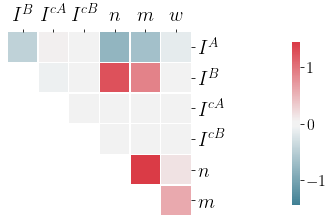

[[ True False False False False False False]
 [ True  True False False False False False]
 [ True  True  True False False False False]
 [ True  True  True  True False False False]
 [ True  True  True  True  True False False]
 [ True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True]]
[[ 0.         -0.44922846  0.02016478  0.03792187  1.25845839  0.9237959
   0.12261381]
 [ 0.          0.         -0.01119746 -0.0801906  -0.77827905 -0.58179685
  -0.06690215]
 [ 0.          0.          0.         -0.03135556  0.02769243  0.06185715
   0.00172282]
 [ 0.          0.          0.          0.          0.04496377 -0.0590533
  -0.0258089 ]
 [ 0.          0.          0.          0.          0.          1.4114485
   0.21718047]
 [ 0.          0.          0.          0.          0.          0.
   0.56908554]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]


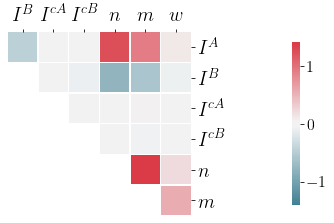

In [21]:
lsize = 20
plt.rcParams['text.usetex'] = True

for i in (0, 1):
    rescaled_vectors = [wi1[z==i], wi2[z==i], wi_ctx1[z==i], wi_ctx2[z==i], n[z==i], m[z==i], wo[z==i] / 4]
    ov = helpers.overlap_matrix(rescaled_vectors)
    labels = ['$I^A$', '$I^B$', '$I^{cA}$', '$I^{cB}$', '$n$', '$m$', '$w$']
    bound = np.max((np.abs(np.min(ov)), np.abs(np.max(ov))))
    fig, ax = plt.subplots(figsize=(6, 6))
    helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=.5, figsize=(4, 3), cbar_pad=.3, ax=ax)
    ax.set_xticks(np.array(list(range(len(labels) - 1))) + .5)
    ax.set_xticklabels(labels[1:])
    ax.set_yticks(np.array(list(range(len(labels) - 1))) + .5)
    ax.set_yticklabels(labels[:-1])
    ax.xaxis.set_tick_params(labelsize=lsize, rotation=0)
    ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
    # plt.savefig(f'si_networks/mante_overlap{i}.pdf', bbox_inches='tight')
    plt.show()

## SI figure state-space plots

In [22]:
plt.rcParams['text.usetex'] = True

c1 = .5
c2 = 1

net.noise_std = noise_std
x = torch.zeros((20, 32, mante.total_duration, 4))
x[:, :, :, :2] += mante.std_default * torch.zeros((1, mante.total_duration, 2))
x[:, [0, 1, 2, 3, 16, 17, 18, 19], mante.stim_begin:mante.stim_end, 0] += c1 * mante.SCALE
x[:, [4, 5, 6, 7, 20, 21, 22, 23], mante.stim_begin:mante.stim_end, 0] += c2 * mante.SCALE
x[:, [8, 9, 10, 11, 24, 25, 26, 27], mante.stim_begin:mante.stim_end, 0] += -c1 * mante.SCALE
x[:, [12, 13, 14, 15, 28, 29, 30, 31], mante.stim_begin:mante.stim_end, 0] += -c2 * mante.SCALE
x[:, [0, 4, 8, 12, 16, 20, 24, 28], mante.stim_begin:mante.stim_end, 1] += c1 * mante.SCALE
x[:, [1, 5, 9, 13, 17, 21, 25, 29], mante.stim_begin:mante.stim_end, 1] += c2 * mante.SCALE
x[:, [2, 6, 10, 14, 18, 22, 26, 30], mante.stim_begin:mante.stim_end, 1] += -c1 * mante.SCALE
x[:, [3, 7, 11, 15, 19, 23, 27, 31], mante.stim_begin:mante.stim_end, 1] += -c2 * mante.SCALE
x[:, :16, mante.fixation_duration_discrete:mante.response_begin, 2] += mante.SCALE_CTX
x[:, 16:, mante.fixation_duration_discrete:mante.response_begin, 3] += mante.SCALE_CTX
x = x.T.reshape((4, mante.total_duration, -1)).T
outp1, trajectories = net.forward(x, return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates = np.tanh(trajectories)
time = time_mapping(np.arange(x.shape[1]))
rates = rates.T.reshape((rates.shape[-1], rates.shape[-2], 32, 20)).T

In [23]:
Ia_orth = wi1 - (wi1 @ m) / (m @ m) * m
Ib_orth = wi2 - (wi2 @ m) / (m @ m) * m

proj_Ia = rates @ Ia_orth
proj_Ib = rates @ Ib_orth
proj_m = rates @ m

col1 = 'firebrick'
col2 = 'royalblue'
col3 = 'green'
col4 = 'blueviolet'

Text(800, -100, '$\\mathbf{m}$')

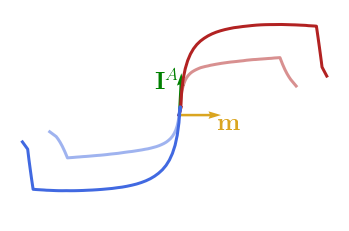

In [24]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [0, 1, 2, 3]].mean(axis=(0, 1)), proj_Ia[:, [0, 1, 2, 3]].mean(axis=(0, 1)), c=col1, alpha=.5, lw=3)
ax.plot(proj_m[:, [4, 5, 6, 7]].mean(axis=(0, 1)), proj_Ia[:, [4, 5, 6, 7]].mean(axis=(0, 1)), c=col1, alpha=1, lw=3)
ax.plot(proj_m[:, 8:12].mean(axis=(0, 1)), proj_Ia[:, 8:12].mean(axis=(0, 1)), c=col2, alpha=.5, lw=3)
ax.plot(proj_m[:, 12:16].mean(axis=(0, 1)), proj_Ia[:, 12:16].mean(axis=(0, 1)), c=col2, alpha=1, lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)

ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi1 @ Ia_orth / (Ia_orth @ Ia_orth), scale=8, color='green')
ax.text(-500, 200, '$\mathbf{I}^A$', size=25, color='green')
ax.text(800, -100, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/1.pdf', bbox_inches='tight')

Text(800, -100, '$\\mathbf{m}$')

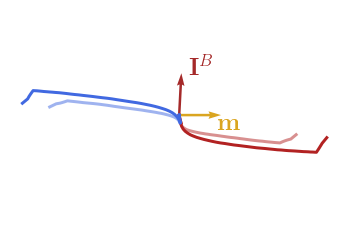

In [25]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [0, 1, 2, 3]].mean(axis=(0, 1)), proj_Ib[:, [0, 1, 2, 3]].mean(axis=(0, 1)), c=col1, alpha=.5, lw=3)
ax.plot(proj_m[:, [4, 5, 6, 7]].mean(axis=(0, 1)), proj_Ib[:, [4, 5, 6, 7]].mean(axis=(0, 1)), c=col1, alpha=1, lw=3)
ax.plot(proj_m[:, 8:12].mean(axis=(0, 1)), proj_Ib[:, 8:12].mean(axis=(0, 1)), c=col2, alpha=.5, lw=3)
ax.plot(proj_m[:, 12:16].mean(axis=(0, 1)), proj_Ib[:, 12:16].mean(axis=(0, 1)), c=col2, alpha=1, lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)

ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi2 @ Ib_orth / (Ib_orth @ Ib_orth), scale=8, color='brown')
ax.text(+200, 300, '$\mathbf{I}^B$', size=25, color='brown')
ax.text(800, -100, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/2.pdf', bbox_inches='tight')

Text(800, -100, '$\\mathbf{m}$')

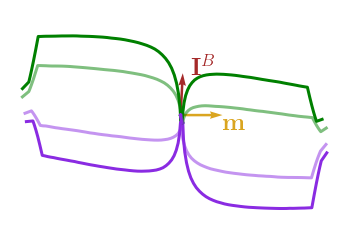

In [26]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [0, 4]].mean(axis=(0, 1)), proj_Ib[:, [0, 4]].mean(axis=(0, 1)), c=col3, alpha=.5, lw=3)
ax.plot(proj_m[:, [1, 5]].mean(axis=(0, 1)), proj_Ib[:, [1, 5]].mean(axis=(0, 1)), c=col3, alpha=1, lw=3)
ax.plot(proj_m[:, [2, 6]].mean(axis=(0, 1)), proj_Ib[:, [2, 6]].mean(axis=(0, 1)), c=col4, alpha=.5, lw=3)
ax.plot(proj_m[:, [3, 7]].mean(axis=(0, 1)), proj_Ib[:, [3, 7]].mean(axis=(0, 1)), c=col4, alpha=1, lw=3)
ax.plot(proj_m[:, [8, 12]].mean(axis=(0, 1)), proj_Ib[:, [8, 12]].mean(axis=(0, 1)), c=col3, alpha=.5, lw=3)
ax.plot(proj_m[:, [9, 13]].mean(axis=(0, 1)), proj_Ib[:, [9, 13]].mean(axis=(0, 1)), c=col3, alpha=1, lw=3)
ax.plot(proj_m[:, [10, 14]].mean(axis=(0, 1)), proj_Ib[:, [10, 14]].mean(axis=(0, 1)), c=col4, alpha=.5, lw=3)
ax.plot(proj_m[:, [11, 15]].mean(axis=(0, 1)), proj_Ib[:, [11, 15]].mean(axis=(0, 1)), c=col4, alpha=1, lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)
ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi2 @ Ib_orth / (Ib_orth @ Ib_orth), scale=8, color='brown')
ax.text(+200, 300, '$\mathbf{I}^B$', size=25, color='brown')
ax.text(800, -100, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/3.pdf', bbox_inches='tight')

Text(800, -100, '$\\mathbf{m}$')

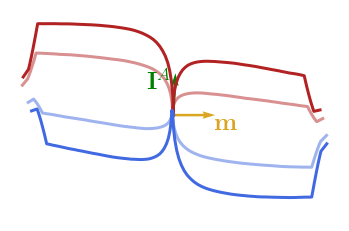

In [27]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [16, 17]].mean(axis=(0, 1)), proj_Ia[:, [16, 17]].mean(axis=(0, 1)), c=col1, alpha=.5, lw=3)
ax.plot(proj_m[:, [20, 21]].mean(axis=(0, 1)), proj_Ia[:, [20, 21]].mean(axis=(0, 1)), c=col1, alpha=1., lw=3)
ax.plot(proj_m[:, [24, 25]].mean(axis=(0, 1)), proj_Ia[:, [24, 25]].mean(axis=(0, 1)), c=col2, alpha=.5, lw=3)
ax.plot(proj_m[:, [28, 29]].mean(axis=(0, 1)), proj_Ia[:, [28, 29]].mean(axis=(0, 1)), c=col2, alpha=1., lw=3)
ax.plot(proj_m[:, [18, 19]].mean(axis=(0, 1)), proj_Ia[:, [18, 19]].mean(axis=(0, 1)), c=col1, alpha=.5, lw=3)
ax.plot(proj_m[:, [22, 23]].mean(axis=(0, 1)), proj_Ia[:, [22, 23]].mean(axis=(0, 1)), c=col1, alpha=1., lw=3)
ax.plot(proj_m[:, [26, 27]].mean(axis=(0, 1)), proj_Ia[:, [26, 27]].mean(axis=(0, 1)), c=col2, alpha=.5, lw=3)
ax.plot(proj_m[:, [30, 31]].mean(axis=(0, 1)), proj_Ia[:, [30, 31]].mean(axis=(0, 1)), c=col2, alpha=1., lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)
ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi1 @ Ia_orth / (Ia_orth @ Ia_orth), scale=8, color='green')
ax.text(-500, 200, '$\mathbf{I}^A$', size=25, color='green')
ax.text(800, -100, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/4.pdf', bbox_inches='tight')

Text(800, -100, '$\\mathbf{m}$')

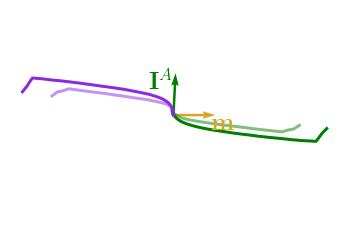

In [28]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [16, 20, 24, 28]].mean(axis=(0, 1)), proj_Ia[:, [16, 20, 24, 28]].mean(axis=(0, 1)), c=col3, alpha=.5, lw=3)
ax.plot(proj_m[:, [17, 21, 25, 29]].mean(axis=(0, 1)), proj_Ia[:, [17, 21, 25, 29]].mean(axis=(0, 1)), c=col3, alpha=1., lw=3)
ax.plot(proj_m[:, [18, 22, 26, 30]].mean(axis=(0, 1)), proj_Ia[:, [18, 22, 26, 30]].mean(axis=(0, 1)), c=col4, alpha=.5, lw=3)
ax.plot(proj_m[:, [19, 23, 27, 31]].mean(axis=(0, 1)), proj_Ia[:, [19, 23, 27, 31]].mean(axis=(0, 1)), c=col4, alpha=1., lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)
ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi1 @ Ia_orth / (Ia_orth @ Ia_orth), scale=8, color='green')
ax.text(-500, 200, '$\mathbf{I}^A$', size=25, color='green')
ax.text(800, -100, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/5.pdf', bbox_inches='tight')

Text(800, -40, '$\\mathbf{m}$')

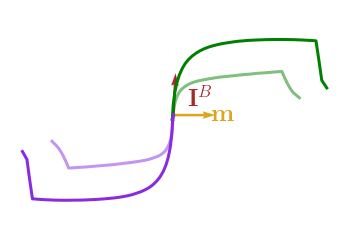

In [29]:
fig, ax = plt.subplots()
ax.plot(proj_m[:, [16, 20, 24, 28]].mean(axis=(0, 1)), proj_Ib[:, [16, 20, 24, 28]].mean(axis=(0, 1)), c=col3, alpha=.5, lw=3)
ax.plot(proj_m[:, [17, 21, 25, 29]].mean(axis=(0, 1)), proj_Ib[:, [17, 21, 25, 29]].mean(axis=(0, 1)), c=col3, alpha=1., lw=3)
ax.plot(proj_m[:, [18, 22, 26, 30]].mean(axis=(0, 1)), proj_Ib[:, [18, 22, 26, 30]].mean(axis=(0, 1)), c=col4, alpha=.5, lw=3)
ax.plot(proj_m[:, [19, 23, 27, 31]].mean(axis=(0, 1)), proj_Ib[:, [19, 23, 27, 31]].mean(axis=(0, 1)), c=col4, alpha=1., lw=3)
ax.set_axis_off()
ax.set_ylim(-800, 800)
ax.quiver(0, 0, 1, 0, scale=8, color='goldenrod')
ax.quiver(0, 0, wi1 @ m / (m @ m), wi2 @ Ib_orth / (Ib_orth @ Ib_orth), scale=8, color='brown')
ax.text(+300, 70, '$\mathbf{I}^B$', size=25, color='brown')
ax.text(800, -40, '$\mathbf{m}$', size=25, color='goldenrod')

# plt.savefig('si_mante/6.pdf', bbox_inches='tight')